In [1]:
import os
import pandas as pd
from collections import defaultdict
from scipy.special import softmax
from tools.model_func import *
import scipy.sparse as sp
import pickle

W0830 15:09:42.540455 139812013717312 deprecation_wrapper.py:119] From /home/angela/xmtc/tools/model_func.py:21: The name tf.keras.layers.CuDNNLSTM is deprecated. Please use tf.compat.v1.keras.layers.CuDNNLSTM instead.



In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [3]:
def get_pAtk(y_true,y_pred,k,per_label=False):
    y_true_sparse = np.argmax(np.asarray(y_true),axis=1)
    Atk = np.any(y_true_sparse[:,np.newaxis]==y_pred[:,:k],axis=1).astype(int)
    if per_label:
        lab = []
        for i in range(y_true.shape[-1]):
            lab.append(np.mean(Atk[y_true_sparse==i]))
        return np.array(lab)
    else:
        return np.mean(Atk)

# get outputs

In [4]:
def get_args(in_dir):
    dirs = sorted([os.path.join(in_dir,d) for d in os.listdir(in_dir)])
    out_d = defaultdict(list)
    for d in dirs:
        log_dir = os.path.join(d,'train.log')
        args_dir = os.path.join(d,'args.csv')
        if not os.path.exists(log_dir) or not os.path.exists(args_dir):
            continue
        df = pd.read_csv(log_dir)
        arg = pd.read_csv(args_dir)
        mode = arg.loc[0,'mode']
        arg['dir'] = d
        df['dir'] = d
        out_d[mode].append(df)   
        out_d['args'].append(arg)
    args = pd.concat(out_d['args'], ignore_index = True, sort = False)
    if 'Unnamed: 0' in args.columns:
        args.drop(columns=['Unnamed: 0'],inplace=True)
    return args

In [5]:
IN_DIR = 'outputs'
args = get_args(IN_DIR)

# manually fix all categorical probs

In [11]:
df = args
df = df[df['mode']=='cat']
df = df[df['loss']=='categorical']
df

,batch_size,epoch,input,loss,mode,model,output,save_model,save_prediction,save_weights,dir,gpu,bert_bottle_neck,bert_trainable_layers,val
9,128,5,data/sic_hierarchy,categorical,cat,xmlcnn,outputs,True,True,True,outputs/190726_210000_xmlcnn,NaN,NaN,NaN,NaN
10,20,5,data/sic_hierarchy,categorical,cat,attentionxml,outputs,True,True,True,outputs/190726_210738_attentionxml,NaN,NaN,NaN,NaN
11,25,5,data/sic_hierarchy,categorical,cat,attention,outputs,True,True,True,outputs/190726_224702_attention,NaN,NaN,NaN,NaN
18,256,3,data/sic_hierarchy,categorical,cat,bert,temp_bert,True,True,True,outputs/190810_151748_bert,"0,1",512.0,3.0,NaN
21,256,3,data/sic_hierarchy,categorical,cat,bert,outputs,True,True,True,outputs/190816_003525_bert,"0,1",512.0,3.0,False
26,128,5,data/amazon_hierarchy_2,categorical,cat,xmlcnn,outputs,False,True,True,outputs/190823_172116_xmlcnn,"0,1",512.0,10.0,False
27,20,5,data/amazon_hierarchy_2,categorical,cat,attentionxml,outputs,False,True,True,outputs/190823_174301_attentionxml,"0,1",512.0,10.0,False
28,25,5,data/amazon_hierarchy_2,categorical,cat,attention,outputs,False,True,True,outputs/190824_133144_attention,"0,1",512.0,10.0,False
29,50,3,data/amazon_hierarchy_2,categorical,cat,bert,outputs,False,True,True,outputs/190824_215412_bert,"0,1",512.0,3.0,False


In [ ]:
# sneaky, only use top 10 preds
for model_dir in sorted(df.dir.to_list()):
    prob_dirs = sorted([os.path.join(model_dir,d) for d in os.listdir(model_dir) if d.startswith('pred_probs')])
    if prob_dirs:
        print('EXISTS: {}'.format(model_dir))
        continue
    logit_dirs = sorted([os.path.join(model_dir,d) for d in os.listdir(model_dir) if d.startswith('pred_logits')])
    prob_dirs = [os.path.join(model_dir,'pred_probs{}.txt'.format(i)) for i in range(len(logit_dirs))]
    logits = [np.loadtxt(l) for l in logit_dirs]
    probs = [softmax(y,axis=1) for y in logits]
    for i,prob in enumerate(probs):
        np.savetxt(prob_dirs[i],prob,fmt='%1.3f')
    print('SAVED: {}'.format(model_dir))

In [31]:
# do it properly (requires GPU)
from tensorflow.keras.models import model_from_json
import tensorflow as tf


for row in df.index:
    with tf.Session() as sess:
        in_dir, model_dir, model_name, mode = args.loc[row,['input','dir','model','mode']]
        if 'attention' in model_name:
            continue
        print(model_dir)
        has_probs = [d for d in os.listdir(model_dir) if d.startswith('pred_probs')]
        if has_probs:
            print("SKIP DIR, prediction exists: {}".format(' '.join(has_probs)))
            continue

        # get input
        if model_name == 'bert':
            _,_,x_tests,y_tests = get_bert_input(in_dir,mode)
        else:
            _,_,x_tests,y_tests = get_input(in_dir,mode,get_output=[0,0,1,1])
        max_sequence_length = len(x_tests[0][0])
        labels_dims = [l.shape[-1] for l in y_tests]
        if model_name == 'bert':
            model = get_bert_model(max_sequence_length, labels_dims,
                                bottle_neck = args.bert_bottle_neck,
                                trainable_layers = args.bert_trainable_layers,
                                sess = sess,
                                )
        else:
            embedding_layer = get_embedding_layer(IN_DIR)
            model = get_model(model_name = args.model,
                              max_sequence_length = max_sequence_length,
                              labels_dims = labels_dims,
                              embedding_layer = embedding_layer)

        model.load_weights(os.path.join(model_dir,'weights.h5'))
        yp = model.predict(x_tests,verbose = 1)
        # GET SOFTMAX PER H
        y_probs = [softmax(y,axis=1) for y in yp]
        ind_dirs = [os.path.join(model_dir,'pred_outputs{}.txt'.format(i)) for i in range(len(y_tests))]
        prob_dirs = [os.path.join(model_dir,'pred_probs{}.txt'.format(i)) for i in range(len(y_tests))]
        print('SAVE RESULTS')
        for i,y_prob in enumerate(y_probs):
            ind = np.argsort(y_prob,axis=1)[:,:-11:-1]
            prob = np.take_along_axis(y_prob, ind, axis=1)
            np.savetxt(ind_dirs[i],ind,fmt='%d')
            np.savetxt(prob_dirs[i],prob,fmt='%1.3f')

# manually get cascade top 10 predictions and save 

In [2]:
# function
def get_cascade_sm(y_preds,IN_DIR):
    child_to_siblings = pickle.load(open(os.path.join(IN_DIR,'child_to_siblings.pkl'),'rb'))
    parent_to_child = pickle.load(open(os.path.join(IN_DIR,'parent_to_child.pkl'),'rb'))
    cascade_sm = [softmax(y_preds[0],axis=1)]
    for i in range(len(y_preds)-1):
        data = []
        row_ind = []
        col_ind = []
        sms = cascade_sm[-1]
        for key,val in parent_to_child[i].items():
            child_sm = softmax(y_preds[i+1][:,val],axis=1)
            data.append(np.multiply(child_sm,sms[:,key,np.newaxis]).reshape(-1))
            row_ind.append(np.repeat(np.arange(sms.shape[0]),len(val)))
            col_ind.append(np.tile(val,sms.shape[0]))
        data = np.concatenate(data)
        row_ind = np.concatenate(row_ind)
        col_ind = np.concatenate(col_ind)
        cascade_sm.append(sp.csr_matrix((data,(row_ind,col_ind))).toarray())
    return cascade_sm

In [ ]:
from keras.models import model_from_json
import tensorflow as tf

masked_categorical_inds = args[args['loss']=='masked_categorical'].index
for masked_categorical_ind in masked_categorical_inds:
    in_dir, model_dir, model_name, mode = args.loc[masked_categorical_ind,['input','dir','model','mode']]
    print(model_dir)
    has_probs = [d for d in os.listdir(model_dir) if d.startswith('pred_probs')]
    if has_probs:
        print("SKIP DIR, prediction exists: {}".format(' '.join(has_probs)))
        continue
    x_train,y_trains,x_test,y_tests = get_input(mode = mode, in_dir = in_dir)
    _,max_sequence_length = x_test.shape
    labels_dims = [l.shape[-1] for l in y_tests]
    embedding_layer = get_embedding_layer(in_dir)
    model = get_model(model_name, max_sequence_length, labels_dims, embedding_layer)
    model.load_weights(os.path.join(model_dir,'weights.h5'))
    yp = model.predict(x_test,verbose = 1)
    print('GET CASCADE SOFTMAX')
    y_probs = get_cascade_sm(yp,in_dir)
    ind_dirs = [os.path.join(model_dir,'pred_outputs{}.txt'.format(i)) for i in range(len(y_tests))]
    prob_dirs = [os.path.join(model_dir,'pred_probs{}.txt'.format(i)) for i in range(len(y_tests))]
    print('SAVE RESULTS')
    for i,y_prob in enumerate(y_probs):
        ind = np.argsort(y_prob,axis=1)[:,:-11:-1]
        prob = np.take_along_axis(y_prob, ind, axis=1)
        np.savetxt(ind_dirs[i],ind,fmt='%d')
        np.savetxt(prob_dirs[i],prob,fmt='%1.3f')
        p1,p5 = get_pAtk(y_tests[i],ind,1),get_pAtk(y_tests[i],ind,5)
        print('H{}, p@1: {:.4f}, p@5: {:.4f}'.format(i,p1,p5))

# get per label p@k

In [15]:
IN_DIR = 'data/sic_hierarchy'
_,y_trains,_,y_tests = get_input(mode='cat', in_dir = IN_DIR, get_output= [0,1,0,1])
train_samples = [np.sum(y,axis=0) for y in y_trains]
freq_orders = [np.argsort(train_sample) for train_sample in train_samples]

df_inds = args[args['input']==IN_DIR].index
patk = []
for df_ind in df_inds:
    model_dir, model_name, mode, loss = args.loc[df_ind,['dir','model','mode','loss']]
    if mode == 'hierarchy':
        continue
#     if loss != 'categorical':
#         continue
    print(model_dir)
    pred_dirs = sorted([os.path.join(model_dir,d) for d in os.listdir(model_dir) if d.startswith('pred_outputs')])
    p1 = []
    p5 = []
    for i,pred_dir in enumerate(pred_dirs):
        y_true = y_tests[i]
        y_pred = np.loadtxt(pred_dirs[i])
        p1.append(get_pAtk(y_true,y_pred,1,per_label=True))
        p5.append(get_pAtk(y_true,y_pred,5,per_label=True))
    patk.append({
        'dir':model_dir,
        'p@1':p1,
        'p@5':p5,
        'model':model_name,
        'loss':loss
    })

outputs/190726_183629_xmlcnn
outputs/190726_184436_attentionxml
outputs/190726_202322_attention
outputs/190726_210000_xmlcnn
outputs/190726_210738_attentionxml
outputs/190726_224702_attention
outputs/190730_141144_xmlcnn
outputs/190730_142304_attentionxml
outputs/190730_202748_attention
outputs/190810_151748_bert
outputs/190816_003525_bert
outputs/190816_054515_bert


# PLOT

In [11]:
import matplotlib.pyplot as plt

In [13]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

### compare diff model

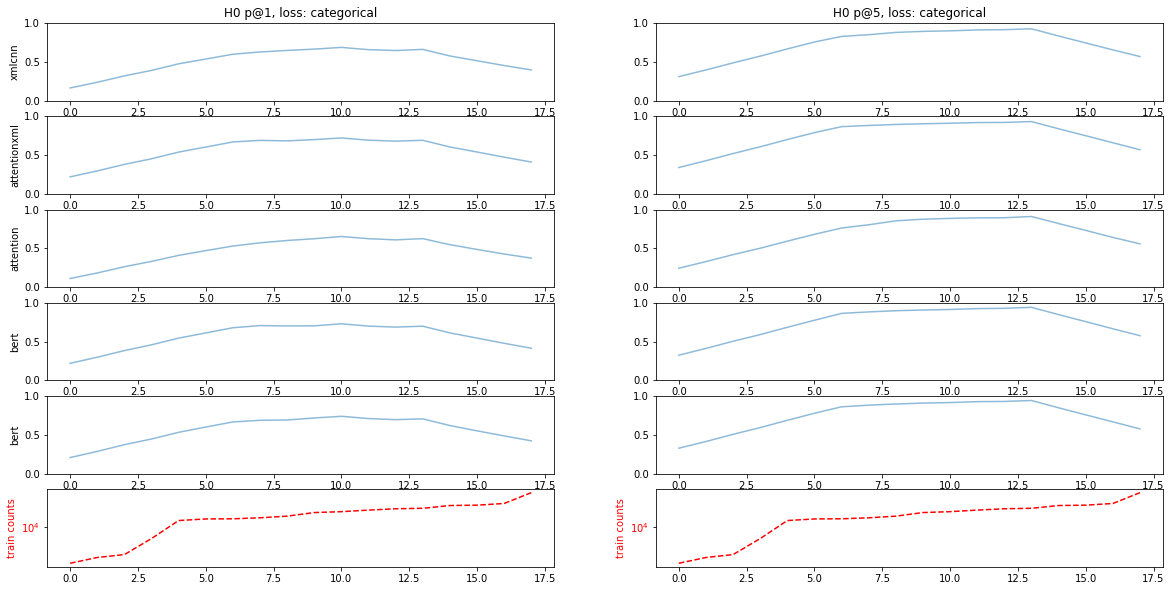

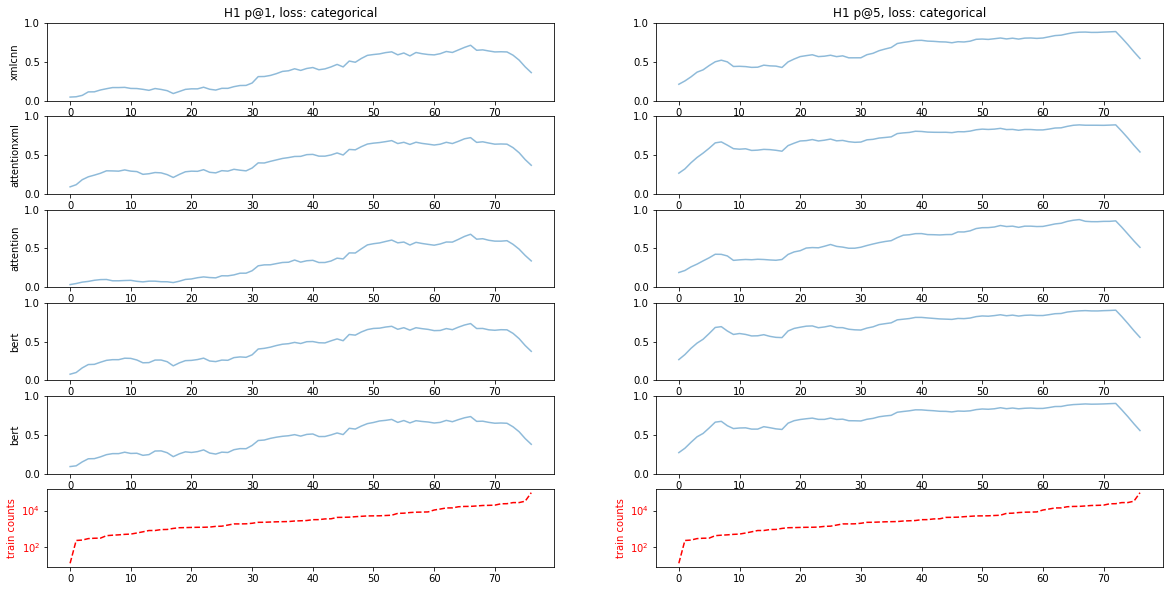

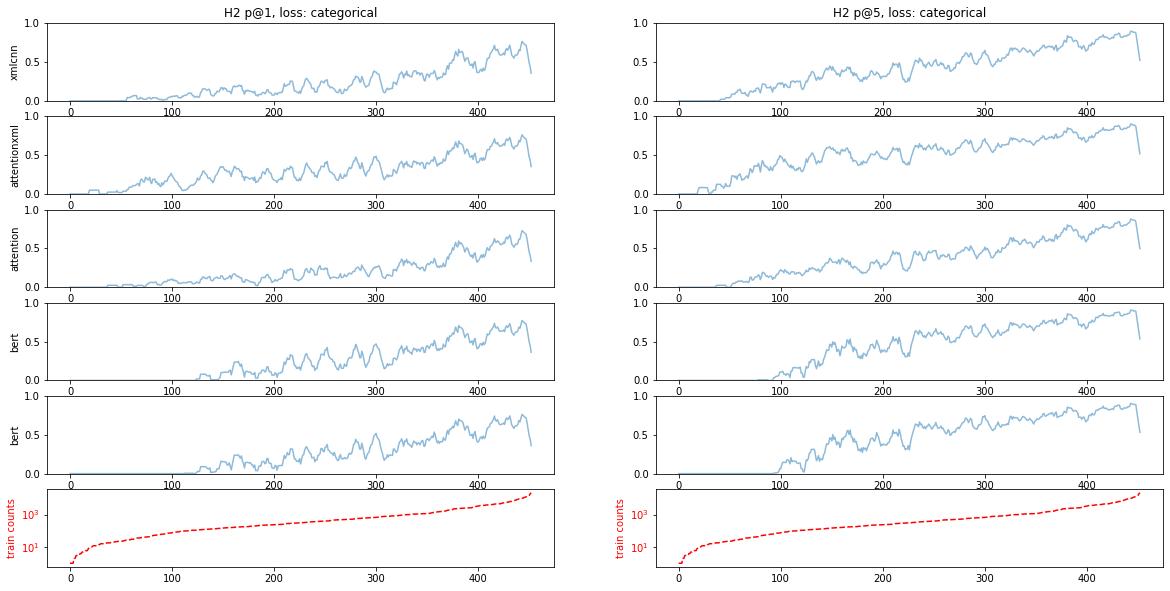

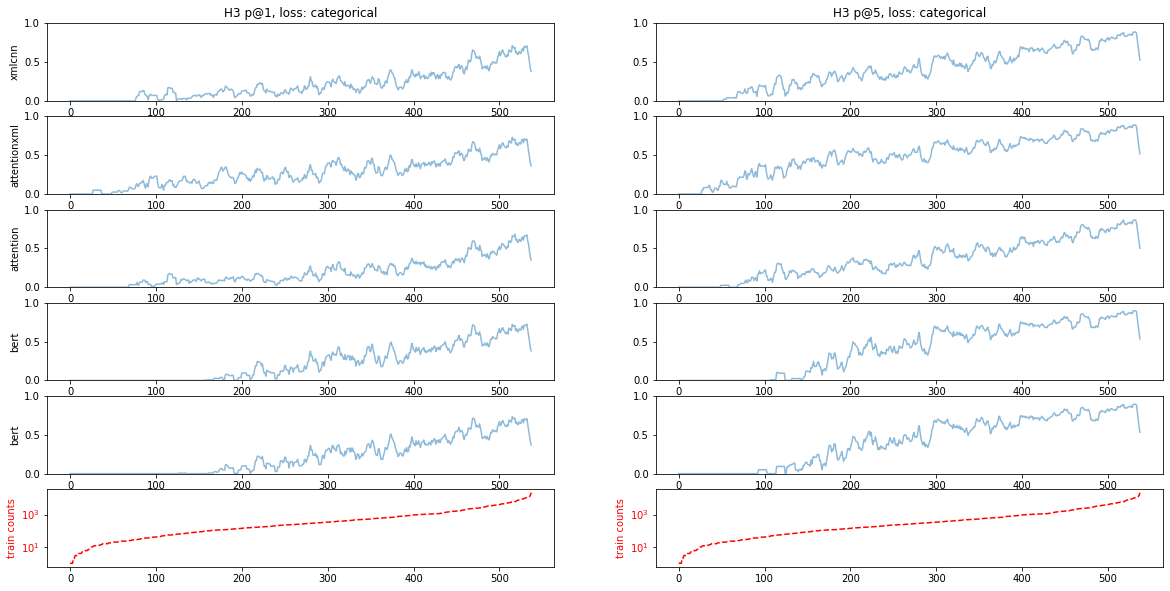

In [14]:
# (diff plot method to emphisise tail labels)
loss = 'categorical'
model_inds = [i for i,model in enumerate(patk) if model['loss']==loss]
alpha = 0.5
for i in range(len(train_samples)):
#     if i!=3:
#         continue
    ind = freq_orders[i]
    fig, axes = plt.subplots(len(model_inds)+1,2,figsize=(20,10))
    axes[0,0].set_title('H{} p@1, loss: {}'.format(i,loss))
    axes[0,1].set_title('H{} p@5, loss: {}'.format(i,loss))
    for ax in [axes[-1,0],axes[-1,1]]:
        ax.plot(train_samples[i][ind],'r--')
        ax.set_ylabel('train counts',color='r')
        ax.tick_params(axis='y', labelcolor='r')
        ax.set_yscale('log')
    for j,model_ind in enumerate(model_inds):
        pat1 = movingaverage(patk[model_ind]['p@1'][i][ind],10)
        pat5 = movingaverage(patk[model_ind]['p@5'][i][ind],10)
        model = patk[model_ind]['model']
        axes[j,0].set_ylabel(model)
        axes[j,0].plot(pat1,alpha=alpha)
        axes[j,1].plot(pat5,alpha=alpha)
        axes[j,0].set_ylim(0,1)
        axes[j,1].set_ylim(0,1)        
    plt.show()


### compare diff loss

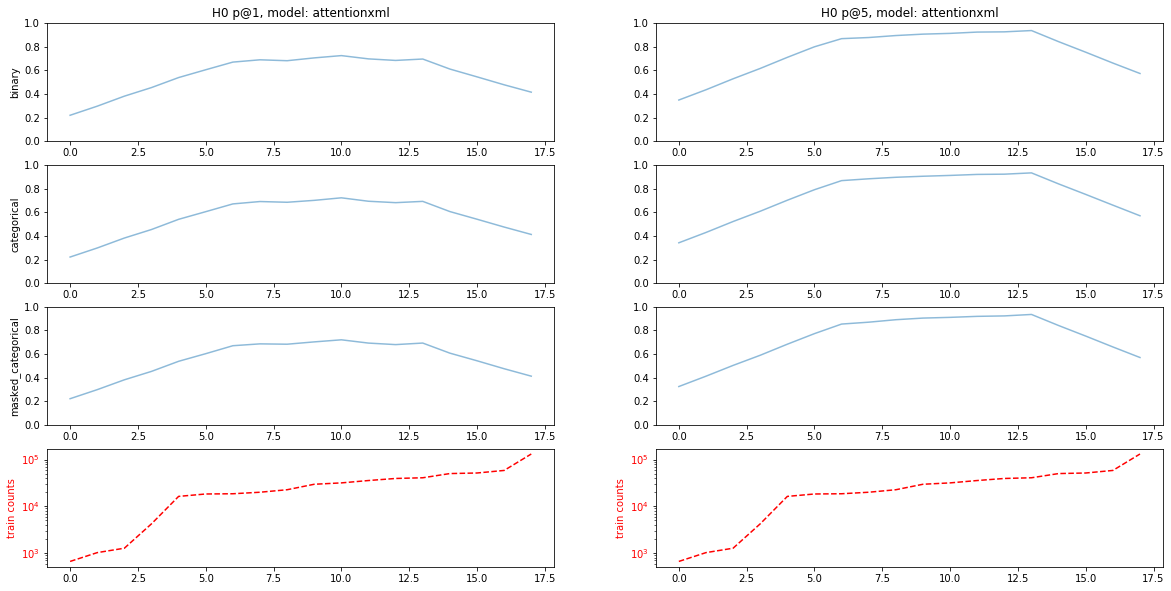

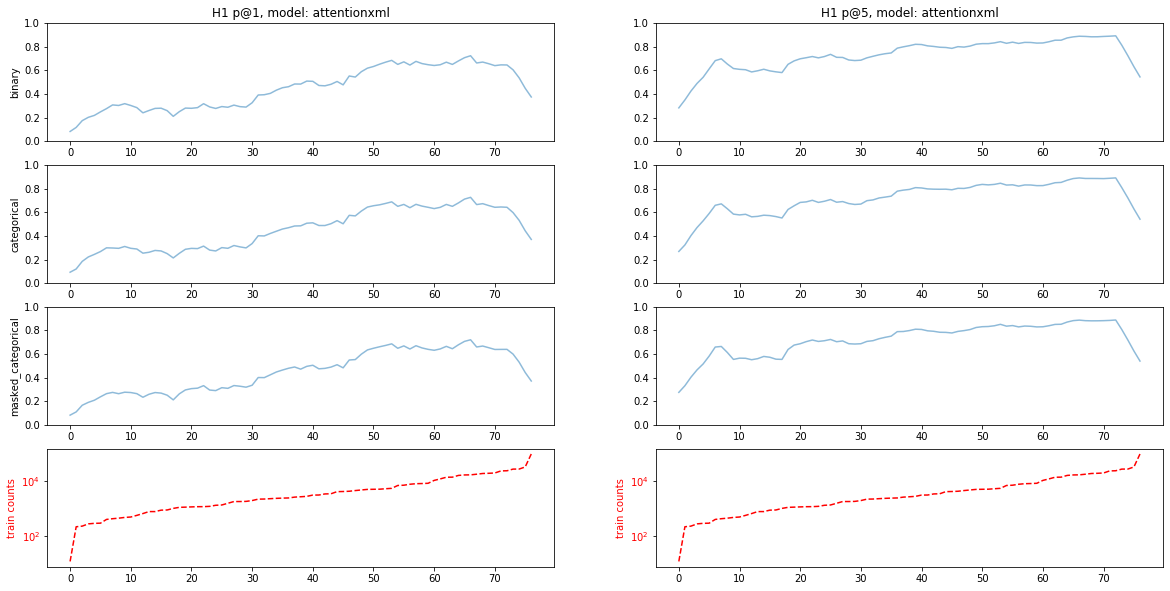

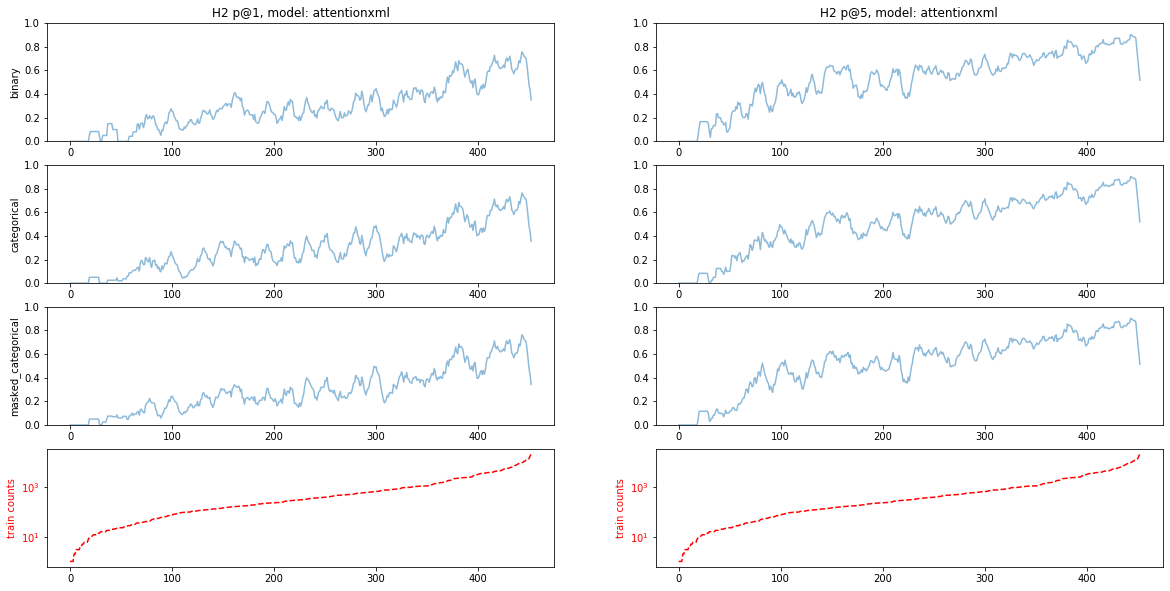

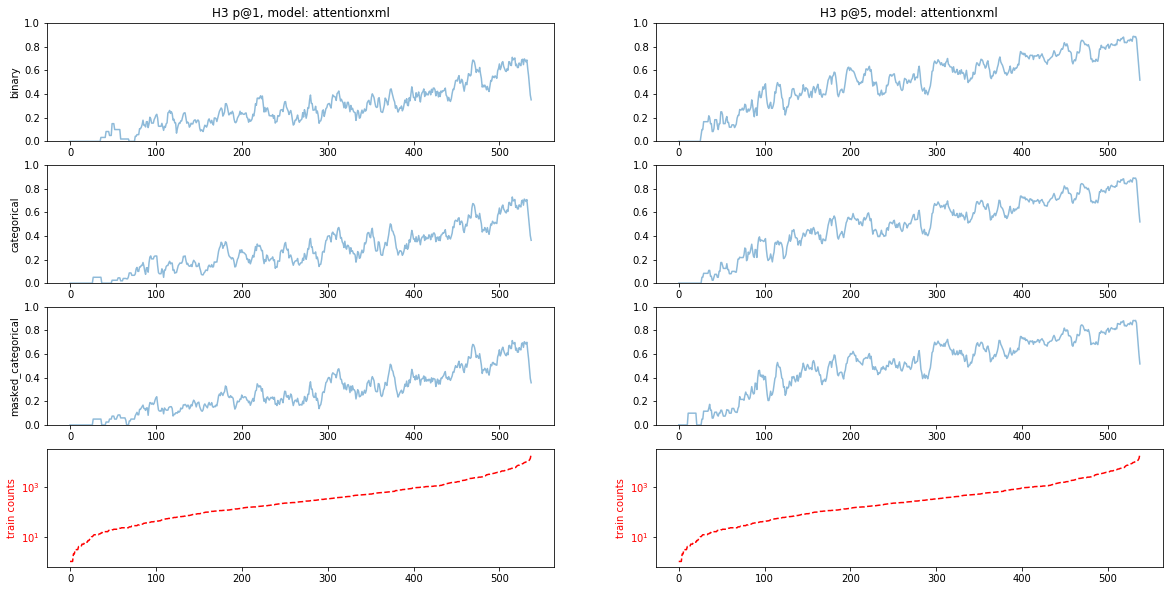

In [19]:
# compare models with same model diff loss (diff plot method to emphisise tail labels)
model_name = 'attentionxml'
model_inds = [i for i,model in enumerate(patk) if model['model']==model_name]
alpha = 0.5
for i in range(len(train_samples)):
#     if i!=3:
#         continue
    ind = freq_orders[i]
    fig, axes = plt.subplots(len(model_inds)+1,2,figsize=(20,10))
    axes[0,0].set_title('H{} p@1, model: {}'.format(i,model_name))
    axes[0,1].set_title('H{} p@5, model: {}'.format(i,model_name))
    for ax in [axes[-1,0],axes[-1,1]]:
        ax.plot(train_samples[i][ind],'r--')
        ax.set_ylabel('train counts',color='r')
        ax.tick_params(axis='y', labelcolor='r')
        ax.set_yscale('log')
    for j,model_ind in enumerate(model_inds):
        pat1 = movingaverage(patk[model_ind]['p@1'][i][ind],10)
        pat5 = movingaverage(patk[model_ind]['p@5'][i][ind],10)
        loss = patk[model_ind]['loss']
        axes[j,0].set_ylabel(loss)
        axes[j,0].plot(pat1,alpha=alpha)
        axes[j,1].plot(pat5,alpha=alpha)
        axes[j,0].set_ylim(0,1)
        axes[j,1].set_ylim(0,1)        
    plt.show()


### plot on one graph

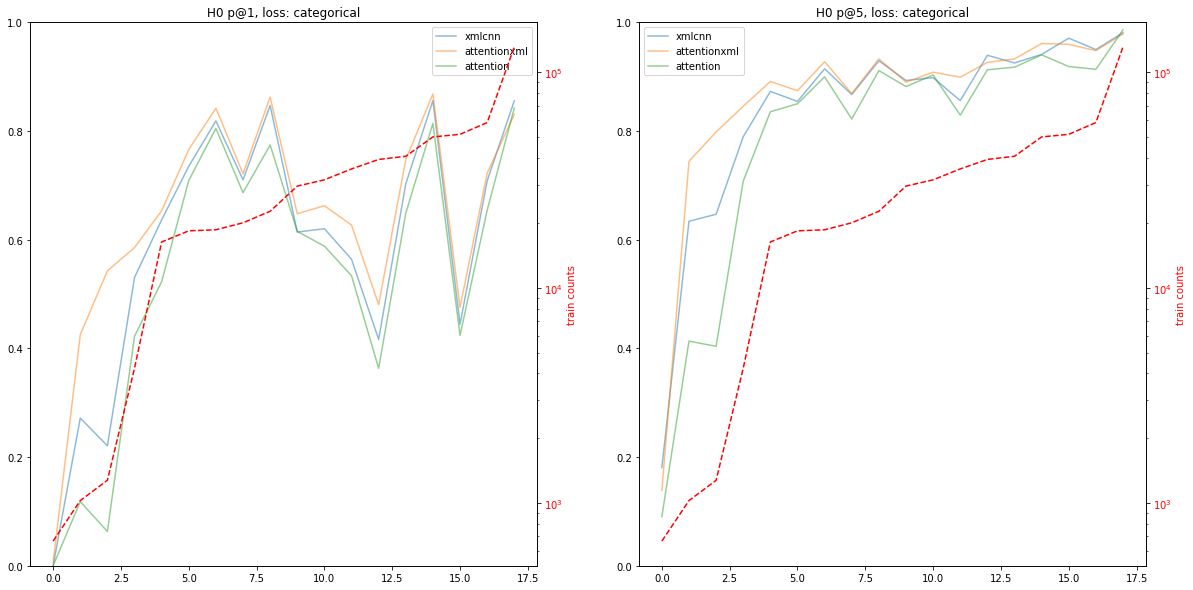

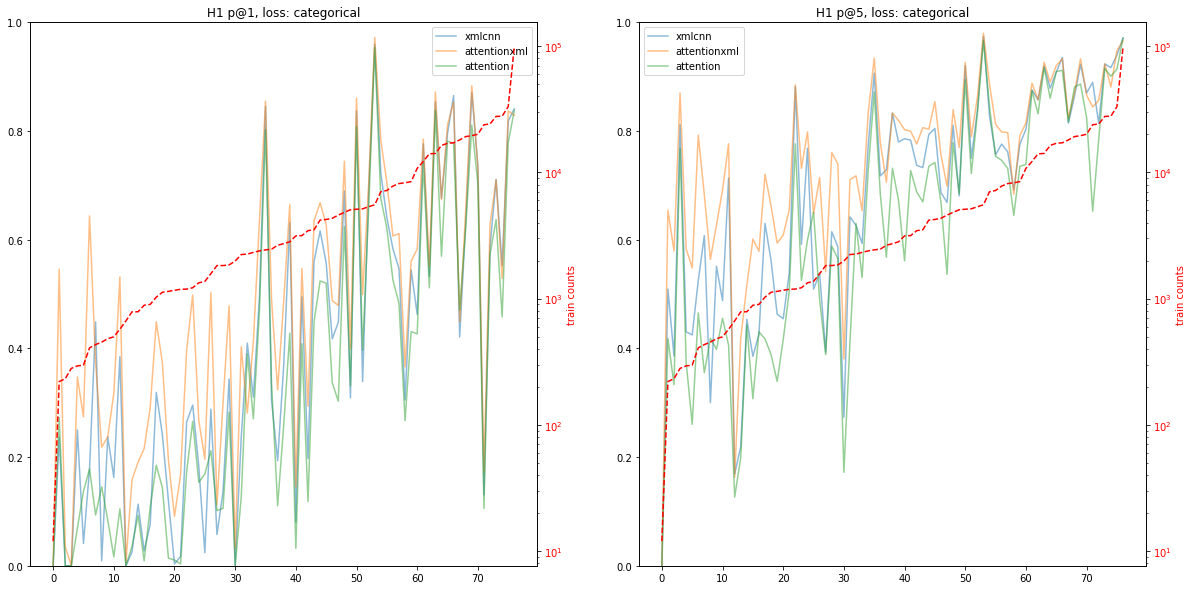

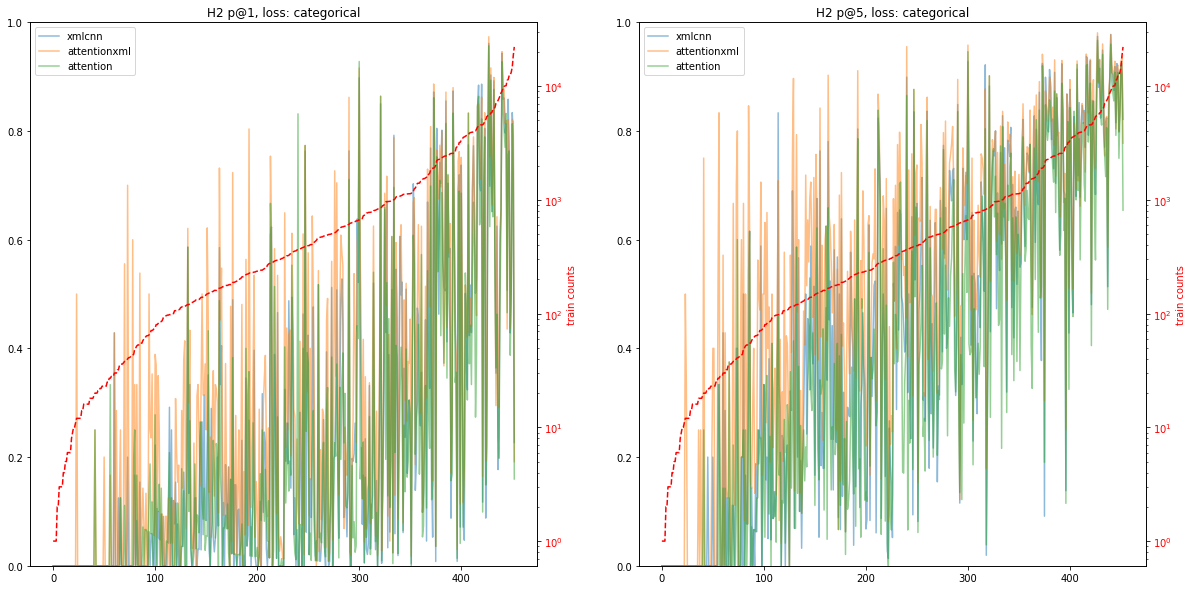

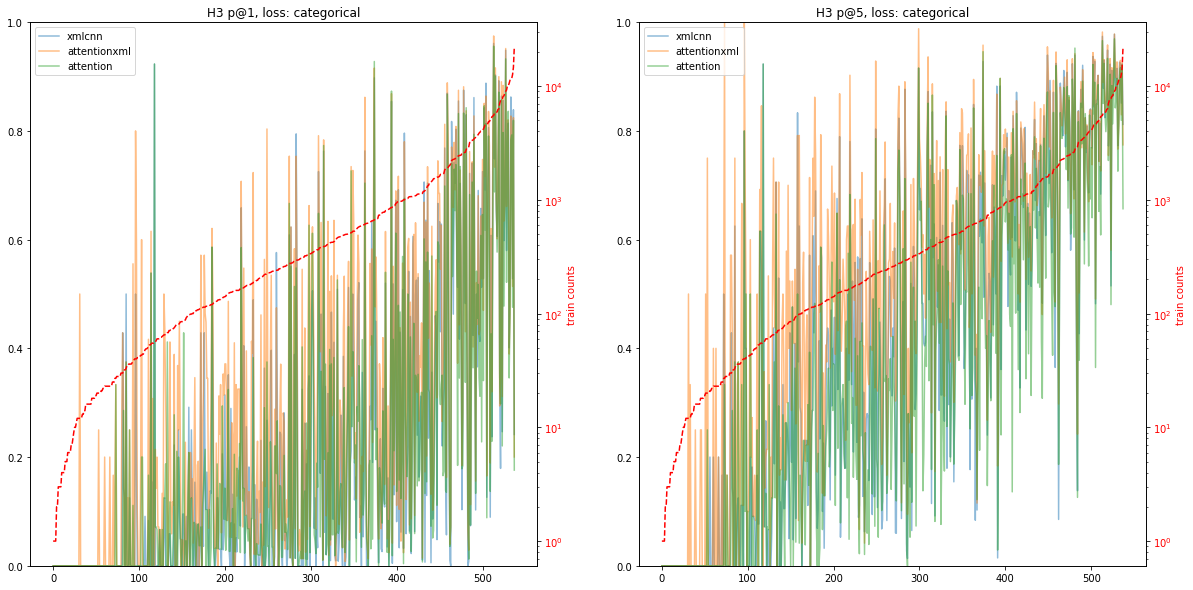

In [9]:
# compare models with same loss diff model
loss = 'categorical'
model_inds = [i for i,model in enumerate(patk) if model['loss']==loss]
alpha = 0.5
for i in range(len(train_samples)):
    ind = freq_orders[i]
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
    ax1.set_title('H{} p@1, loss: {}'.format(i,loss))
    ax2.set_title('H{} p@5, loss: {}'.format(i,loss))
    for ax in [ax1.twinx(),ax2.twinx()]:
        ax.plot(train_samples[i][ind],'r--')
        ax.set_ylabel('train counts',color='r')
        ax.tick_params(axis='y', labelcolor='r')
        ax.set_yscale('log')
    for model_ind in model_inds:
        pat1 = patk[model_ind]['p@1'][i]
        pat5 = patk[model_ind]['p@5'][i]
        model = patk[model_ind]['model']
        ax1.plot(pat1[ind],alpha=alpha,label=model)
        ax2.plot(pat5[ind],alpha=alpha,label=model)
    for ax in [ax1,ax2]:
        ax.set_ylim(0,1)
    ax1.legend()
    ax2.legend()

    plt.show()


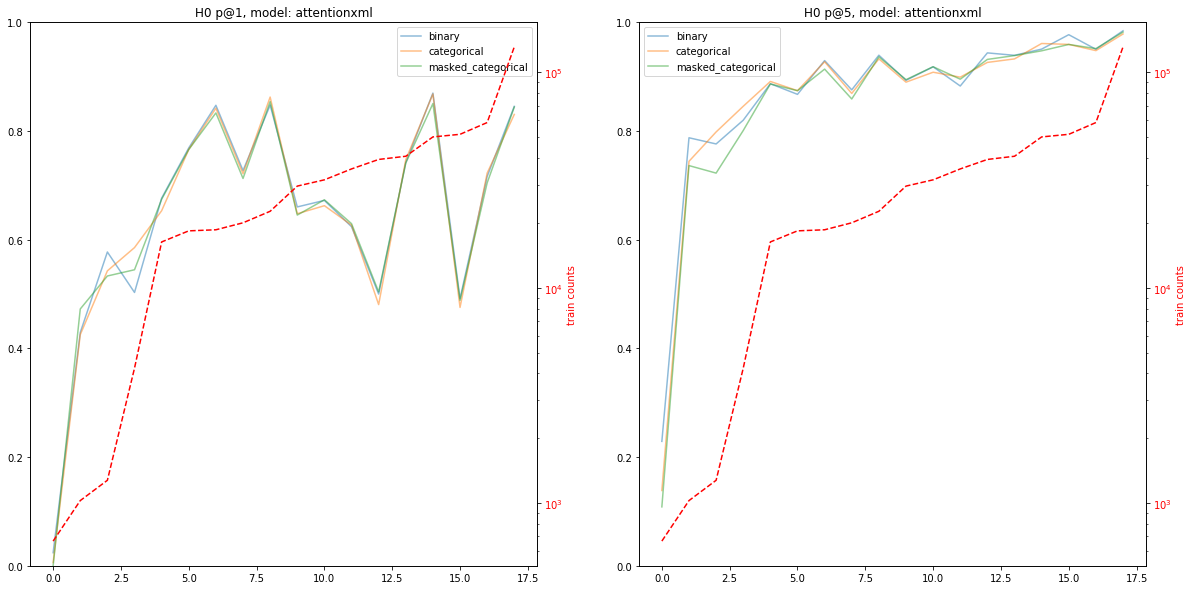

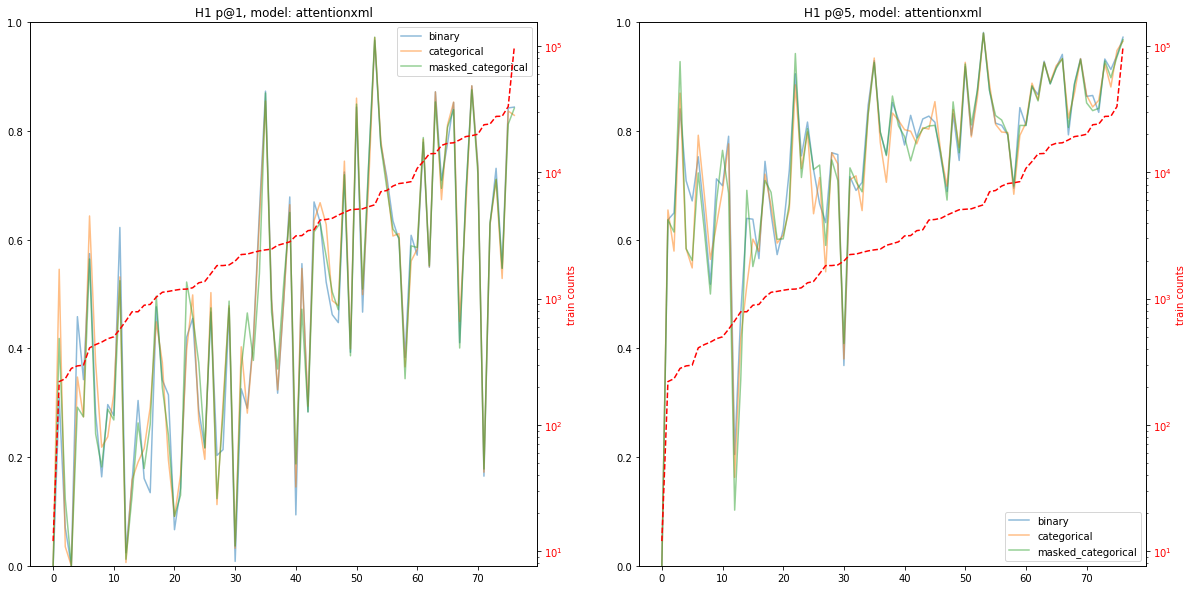

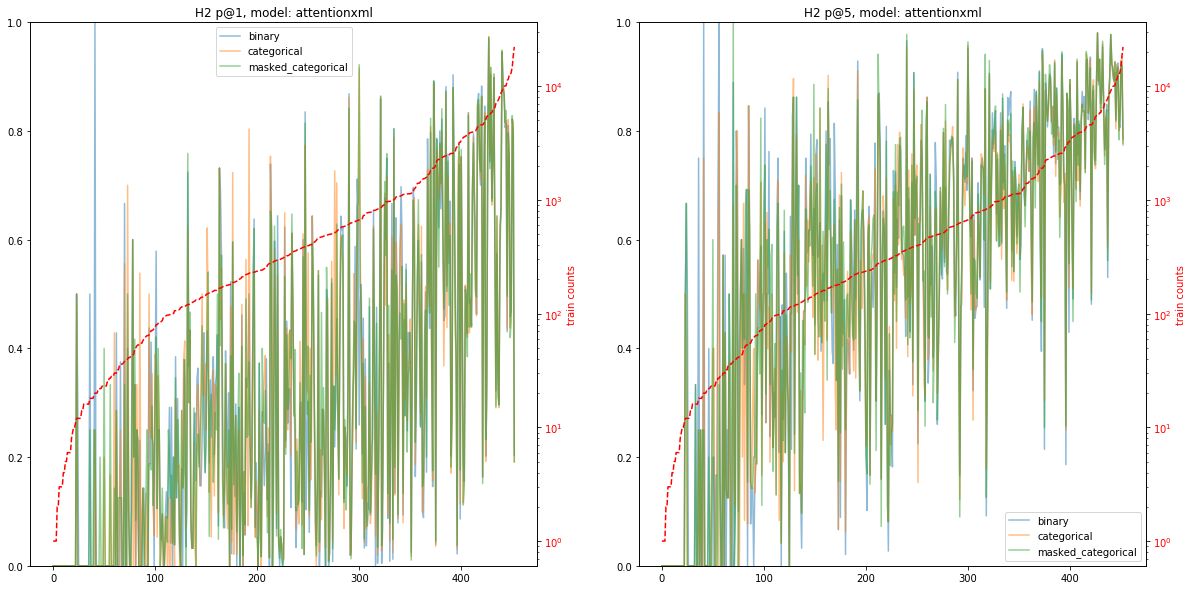

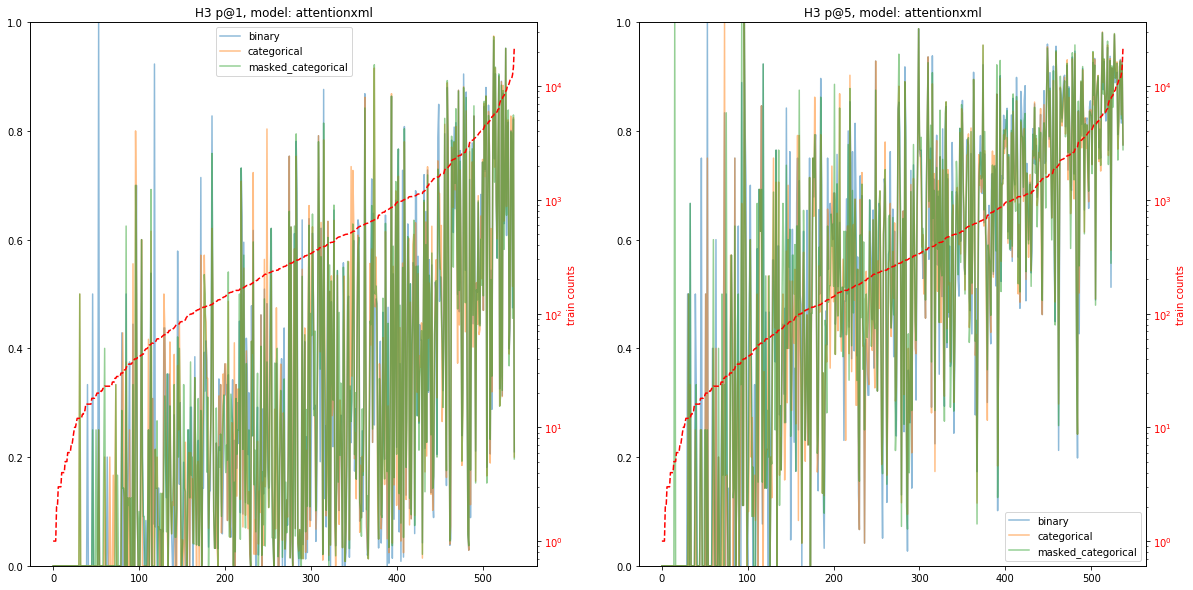

In [33]:
# compare models with same model diff loss
model_name = 'attentionxml'
model_inds = [i for i,model in enumerate(patk) if model['model']==model_name]
alpha = 0.5
for i in range(len(train_samples)):
    ind = freq_orders[i]
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
    ax1.set_title('H{} p@1, model: {}'.format(i,model_name))
    ax2.set_title('H{} p@5, model: {}'.format(i,model_name))
    for ax in [ax1.twinx(),ax2.twinx()]:
        ax.plot(train_samples[i][ind],'r--')
        ax.set_ylabel('train counts',color='r')
        ax.tick_params(axis='y', labelcolor='r')
        ax.set_yscale('log')
    for model_ind in model_inds:
        pat1 = patk[model_ind]['p@1'][i]
        pat5 = patk[model_ind]['p@5'][i]
        loss = patk[model_ind]['loss']
        ax1.plot(pat1[ind],alpha=alpha,label=loss)
        ax2.plot(pat5[ind],alpha=alpha,label=loss)
    for ax in [ax1,ax2]:
        ax.set_ylim(0,1)
    ax1.legend()
    ax2.legend()

    plt.show()


In [22]:
for model in patk:
    print(model['model'],model['loss'])
#     for i in range(len(train_samples)):
#         p1 = np.mean(model['p@1'][i])
#         p5 = np.mean(model['p@5'][i])
#         print('p@1/l:{:.6f} p@5/l: {:.6f}'.format(p1,p5))
    p1 = np.mean(np.concatenate(model['p@1']))
    p5 = np.mean(np.concatenate(model['p@5']))
    print('p@1/l:{:.6f} p@5/l: {:.6f}'.format(p1,p5))

xmlcnn binary
p@1/l:0.192769 p@5/l: 0.368894
attentionxml binary
p@1/l:0.307688 p@5/l: 0.547467
attention binary
p@1/l:0.228839 p@5/l: 0.448778
xmlcnn categorical
p@1/l:0.233072 p@5/l: 0.444067
attentionxml categorical
p@1/l:0.306224 p@5/l: 0.530641
attention categorical
p@1/l:0.213669 p@5/l: 0.397085
xmlcnn masked_categorical
p@1/l:0.237522 p@5/l: 0.455854
attentionxml masked_categorical
p@1/l:0.306720 p@5/l: 0.544397
attention masked_categorical
p@1/l:0.249668 p@5/l: 0.492332
